# DRF Reactive Agents (Part 2)

In this notebook you are going to implement a DRF-based driving behaviour model to control the agents with a protocol named *close-loop* evaluation using Lyft prediction dataset. The reactive agents are the most crucial part of making a reactive simulation.


## What is close-loop and open-loop evaluation?
In close-loop evaluation, the SDV (or other agents) is completely controlled by our customized model throughout a scene. In each scene, the SDV should make ~50 predictions regarding its future position.

Whereas in open-loop evaluation we evaluate our model prediction as we follow the annotated ground truth. In each frame, we compare the predictions of our model against the annotated ground truth.

## What can we use DRF-reactive simulation for?
Simulating other agents is crucial to remove false positive interventions, which occur when agents are log-replayed. As an example, imagine if our SDV was slower compared to the one in the data log. In this situation the car behind us may bump into us if it's just being replayed from the log. Differently, if that agent is equipped with a policy it will be able to react and slow down before colliding with the SDV.

Compared with ML policies, our DRF models can easily simulate diverse driving styles of other road agents by simply tweaking the parameter values. These parameters are easy to tune (only two parameters) and with clear physical meanings. As the DRF models are already validated by Lyft prediction dataset regarding its safety, reactiveness and human-likeness, the models can be directly put into practice to generate realistic traffic scenarios with diverse traffic agent styles.

When evaluating a policy for the SDV, reactive simulation can therefore help in reducing the noise introduced in the metrics by the non-reactive log replayed agents.

## Imports & packages

In [1]:
## from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import cv2
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
#from l5kit.dataset import EgoDatasetVectorized
from Param_Estimation.dataset.ego import EgoDatasetVectorized
from l5kit.vectorization.vectorizer_builder import build_vectorizer
# from l5kit.dataset import EgoDataset
# from l5kit.rasterization import build_rasterizer
from l5kit.geometry import transform_points, angular_distance, transform_point
from l5kit.visualization import TARGET_POINTS_COLOR, PREDICTED_POINTS_COLOR, draw_trajectory
from l5kit.kinematic import AckermanPerturbation
from l5kit.random import GaussianRandomGenerator
# from l5kit.simulation.dataset import SimulationConfig
# from l5kit.simulation.unroll import ClosedLoopSimulator

from Param_Estimation.map.map_builder import MapBuilder
from Param_Estimation.driver.DRFModel import DRFModel
from Param_Estimation.map.rasterizer_builder import build_rasterizer
from Param_Estimation.dataset.ego import EgoDataset
from Param_Estimation.simulation.dataset import SimulationConfig
from Param_Estimation.simulation.unroll import ClosedLoopSimulator

import os

D:\YURUIDU\DRF_Simulation\Param_Estimation\venv\lib\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(
d:\yuruidu\drf_simulation\param_estimation\Param_Estimation\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "."
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./urban_driver_config.yaml")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_path = "./models/BPTT.pt"
model = torch.load(model_path).to(device)
model = model.eval()
torch.set_grad_enabled(False)

D:\YURUIDU\DRF_Simulation\Param_Estimation\venv\lib\site-packages\torch\serialization.py:602: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


## Load the evaluation data
**we don't change our data here**.

When performing evaluation we're interested in knowing the performance on the annotated data.

In [3]:
# ===== INIT DATASET
# for urban driver
eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
vectorizer = build_vectorizer(cfg, dm)
eval_dataset = EgoDatasetVectorized(cfg, eval_zarr, vectorizer, rasterizer)
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


## Reactive simulation setup

In [24]:
num_simulation_steps = 50

# ==== DEFINE CLOSED-LOOP SIMULATION
sim_cfg = SimulationConfig(use_ego_gt=False, use_agents_gt=False, disable_new_agents=True,
                           distance_th_far=100, distance_th_close=100, num_simulation_steps=num_simulation_steps,
                           start_frame_index=5, show_info=True)

sim_loop = ClosedLoopSimulator(sim_cfg, eval_dataset, device, model_ego=model, model_agents=None)

# ==== UNROLL
# scenes_to_unroll = [1400, 1412, 1462, 1463, 9973, 1828, 1849, 1859, 1878, 1987,
#                     6, 19, 21, 35, 37, 64, 71, 114, 158, 167,
#                     199, 209, 256, 290, 300, 331, 333, 335, 9972, 688,
#                     16, 818, 868, 920, 922, 943, 998, 1031, 1059, 1112,
#                     1235, 1319, 1339, 1351, 1381, 1409, 1427, 1511, 1553, 1554, 
#                     1616, 1644, 1678, 1695, 1745, 1757, 1779, 2010, 2065, 2146, 
#                     2171, 2231, 2271, 2306, 2307, 2349, 2372, 2423, 2508, 2517,
#                     2518, 2528, 2567, 2595, 2609, 2640, 2672, 2686, 2688, 2713,
#                     2750, 2883, 2908, 2944, 2946, 2988, 2989, 3048, 3049, 3093,
#                     3048, 3049, 3093, 3115, 3129, 3160, 3161, 3162, 3177, 3194,
#                     1, 11, 17, 31, 60, 85, 91, 99, 104, 106,
#                     159, 194, 196, 240, 251, 353, 474, 487, 544, 605,
#                     619, 647, 754, 799, 830, 832, 835, 894, 919, 946,
#                     951, 991, 1072, 1103, 1108, 1118, 1125, 1152, 1200, 1207,
#                     1217, 1250, 1262, 1280, 1294, 1332, 1333, 1444, 1484, 1587]
scenes_to_unroll = [21]
scenes_to_unroll = np.unique(scenes_to_unroll)
print(len(scenes_to_unroll))

1


In [15]:
from Param_Estimation.cle.closed_loop_evaluator import ClosedLoopEvaluator, EvaluationPlan
from Param_Estimation.cle.metrics import (CollisionFrontMetric, CollisionRearMetric, CollisionSideMetric,
                               DisplacementErrorL2Metric, DistanceToRefTrajectoryMetric, SimulatedVsRecordedEgoSpeedMetric,)
from Param_Estimation.cle.validators import RangeValidator, ValidationCountingAggregator

metrics = [DisplacementErrorL2Metric(),
           DistanceToRefTrajectoryMetric(),
           CollisionFrontMetric(),
           CollisionRearMetric(),
           CollisionSideMetric(),
           SimulatedVsRecordedEgoSpeedMetric()]

validators = [RangeValidator("displacement_error_l2_validator", DisplacementErrorL2Metric, max_value=30),
              RangeValidator("distance_ref_trajectory_validator", DistanceToRefTrajectoryMetric, max_value=4),
              RangeValidator("collision_front_validator", CollisionFrontMetric, max_value=0),
              RangeValidator("collision_rear_validator", CollisionRearMetric, max_value=0),
              RangeValidator("collision_side_validator", CollisionSideMetric, max_value=0),
              RangeValidator("simulated_minus_recorded_ego_speed_validator", SimulatedVsRecordedEgoSpeedMetric, 
                             min_value=-10),#, violation_duration_s=3.0),
              ]

intervention_validators = ["displacement_error_l2_validator",
                           "distance_ref_trajectory_validator",
                           "collision_front_validator",
                           "collision_rear_validator",
                           "collision_side_validator",
                           "simulated_minus_recorded_ego_speed_validator"]

cle_evaluator = ClosedLoopEvaluator(EvaluationPlan(metrics=metrics,
                                    validators=validators,
                                    composite_metrics=[],
                                    intervention_validators=intervention_validators))

## Quantitative evaluation

reactive simulation with RL controlled agents:

In [16]:
sim_cfg = SimulationConfig(use_ego_gt=False, use_agents_gt=False, disable_new_agents=True,
                           distance_th_far=100, distance_th_close=100, num_simulation_steps=num_simulation_steps,
                           start_frame_index=5, show_info=True)

sim_loop = ClosedLoopSimulator(sim_cfg, eval_dataset, device, model_ego=model, model_agents=None)

sim_outs = sim_loop.unroll2(scenes_to_unroll)

D:\YURUIDU\DRF_Simulation\Param_Estimation\venv\lib\site-packages\l5kit\data\zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
d:\yuruidu\drf_simulation\param_estimation\Param_Estimation\simulation\utils.py:152: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")


  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
cle_evaluator.evaluate(sim_outs)
validation_results = cle_evaluator.validation_results()
agg, agg_failed = ValidationCountingAggregator().aggregate(validation_results)
cle_evaluator.reset()
#print(agg_failed)

In [18]:
## Only run this block to get the animation for ONE assigned scene in "scenes_to_unroll"!
# # save animation
# %matplotlib notebook
# import matplotlib.animation as animation
# from matplotlib.patches import Rectangle

# fig = plt.figure()
# p_ims = []

# for p_im in sim_loop.p_ims:
#     p_im = np.asarray(p_im, dtype=int)
#     p_im = np.squeeze(p_im)
#     p_im = plt.imshow(p_im, animated=True)
#     ax = plt.gca()
#     ax.add_patch(Rectangle((48,49.2),4,1.6,linewidth=1,edgecolor='r',facecolor='none'))
#     p_ims.append([p_im])
    
# ani = animation.ArtistAnimation(fig, p_ims, interval=50, blit=True, repeat_delay=1000)
# plt.show() 
# f = r"D:\YURUIDU\DRF_Simulation\Param_Estimation\Param_Estimation\planning\analysis\DRF_l5kit_animation.gif" 
# writergif = animation.PillowWriter(fps=10) 
# ani.save(f, writer=writergif)
# # # save animation

Measure L2-displacements of the agents compared to log-replay.

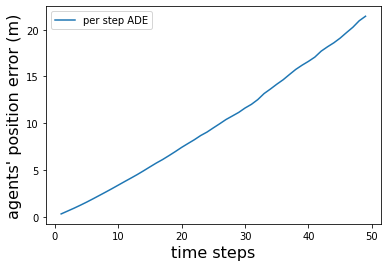

In [19]:
from collections import defaultdict
errors_at_step = defaultdict(list)
for sim_out in sim_outs: # for each scene
    for idx_step, agents_in_out in enumerate(sim_out.agents_ins_outs):  # for each step
        for agent_in_out in agents_in_out:  # for each agent
            annot_pos = agent_in_out.inputs["target_positions"][0]
            annot_pos = transform_point(annot_pos, agent_in_out.inputs["world_from_agent"])
            pred_pos = agent_in_out.outputs["positions"][0]
            if agent_in_out.inputs["target_availabilities"][0] > 0:
                errors_at_step[idx_step + 1].append(np.linalg.norm(pred_pos - annot_pos))

time_steps = np.asarray(list(errors_at_step.keys()))
errors = np.asarray([np.mean(errors_at_step[k]) for k in errors_at_step])
plt.plot(time_steps, errors, label="per step ADE")
plt.xlabel('time steps', fontsize=16)
plt.ylabel('agents\' position error (m)', fontsize=16)
#plt.xticks(time_steps)
plt.legend()
plt.show()

non-reactive simulation with RL controlled agents:

In [20]:
sim_cfg_log = SimulationConfig(use_ego_gt=False, use_agents_gt=True, disable_new_agents=True,
                           distance_th_far=100, distance_th_close=100, num_simulation_steps=num_simulation_steps,
                           start_frame_index=5, show_info=True)

sim_loop_log = ClosedLoopSimulator(sim_cfg_log, eval_dataset, device, model_ego=model)
sim_outs_log = sim_loop_log.unroll(scenes_to_unroll)

D:\YURUIDU\DRF_Simulation\Param_Estimation\venv\lib\site-packages\l5kit\data\zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
d:\yuruidu\drf_simulation\param_estimation\Param_Estimation\simulation\utils.py:152: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")


  0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
cle_evaluator.evaluate(sim_outs_log)
validation_results_log = cle_evaluator.validation_results()
agg_log, agg_log_failed = ValidationCountingAggregator().aggregate(validation_results_log)
cle_evaluator.reset()

Compare non-reactive simulation with reactive simulation.

In [22]:
from prettytable import PrettyTable

fields = ["metric", "log_replayed agents", "simulated agents"]
table = PrettyTable(field_names=fields)
for metric_name in agg:
    table.add_row([metric_name, agg_log[metric_name].item(), agg[metric_name].item()])
print(table)

+----------------------------------------------+---------------------+------------------+
|                    metric                    | log_replayed agents | simulated agents |
+----------------------------------------------+---------------------+------------------+
|       displacement_error_l2_validator        |          7          |        49        |
|      distance_ref_trajectory_validator       |          2          |        6         |
|          collision_front_validator           |          0          |        0         |
|           collision_rear_validator           |          70         |        1         |
|           collision_side_validator           |          2          |        3         |
| simulated_minus_recorded_ego_speed_validator |          5          |        11        |
+----------------------------------------------+---------------------+------------------+


## Qualitative evaluation

Inspect how reactive simulation with RL controlled agents performs.

In [23]:
from Param_Estimation.visualization.visualizer.zarr_utils import simulation_out_to_visualizer_scene
from Param_Estimation.visualization.visualizer.zarr_utils import DRF_simulation_out_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

output_notebook()
mapAPI = MapAPI.from_cfg(dm, cfg)

for sim_out in sim_outs: # for each scene
    vis_in = DRF_simulation_out_to_visualizer_scene(sim_out, mapAPI)
    out_vis = visualize(sim_out.scene_id, vis_in)
    show(out_vis)
    break

Loading BokehJS ...